In [3]:
from matplotlib import pyplot as plt
import pandas as pd

C:\Users\User\AppData\Local\Temp\ipykernel_9380\1160475568.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [34]:
#Читаем файл
df = pd.read_csv("../data/Total annual rainfall in inches London England 1813  1912.csv")
df = df['x']
df.head()

0    23.56
1    26.07
2    21.86
3    31.24
4    23.65
Name: x, dtype: float64

## Предсказание временного ряда с помощью random forest

Random Forest - это алгоритм машинного обучения, который использует множество деревьев решений для прогнозирования

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from numpy import asarray

In [36]:
df.shape

(100,)

In [37]:
n_vars = 1
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [38]:
df.head()

0    23.56
1    26.07
2    21.86
3    31.24
4    23.65
Name: x, dtype: float64

In [39]:
agg.head()

,x,x
1,23.56,26.07
2,26.07,21.86
3,21.86,31.24
4,31.24,23.65
5,23.65,23.88


In [40]:
len(list_for_forecast)

99

In [41]:
# Обучение на основе DecisionTreeRegressor

def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [42]:
# Обучение на основе RandomForestRegressor

def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

### Random Forest

In [43]:
# Random forest
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  3.9921541533613247


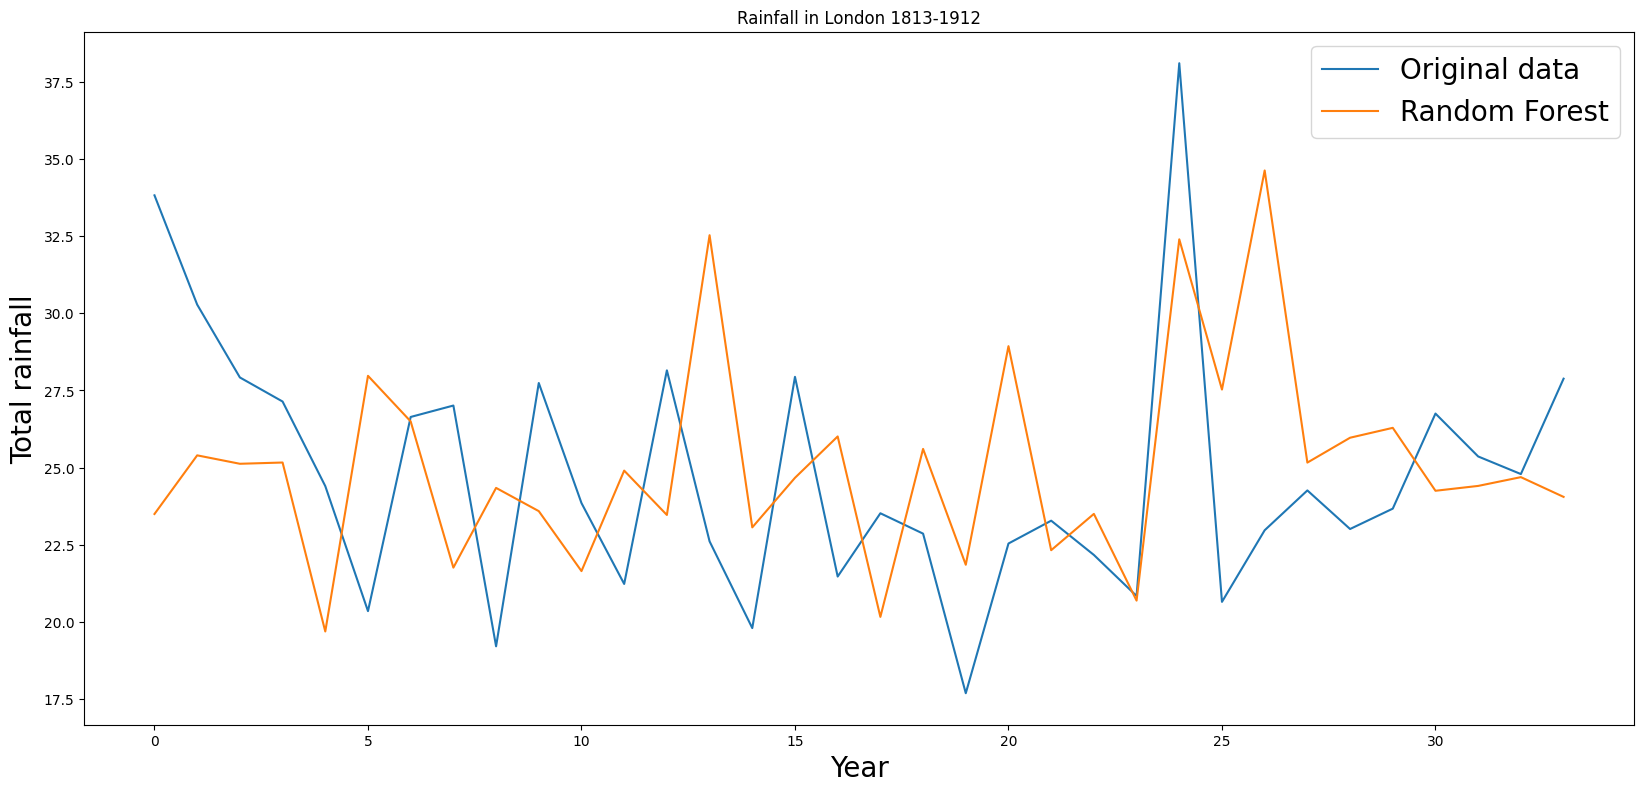

In [44]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Rainfall in London 1813-1912')
plt.ylabel('Total rainfall', fontsize="20")
plt.xlabel('Year', fontsize="20")
plt.show()

In [45]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 4.8744373677198185
MAPE: 0.16518702251568612
MAE: 3.9921541533613247
R2:  -0.4127454830266142


### Дерево решений

In [46]:
predictions2 = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions2.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions2)
print("Desision Tree error: ", error)

Desision Tree error:  4.5988235294117645


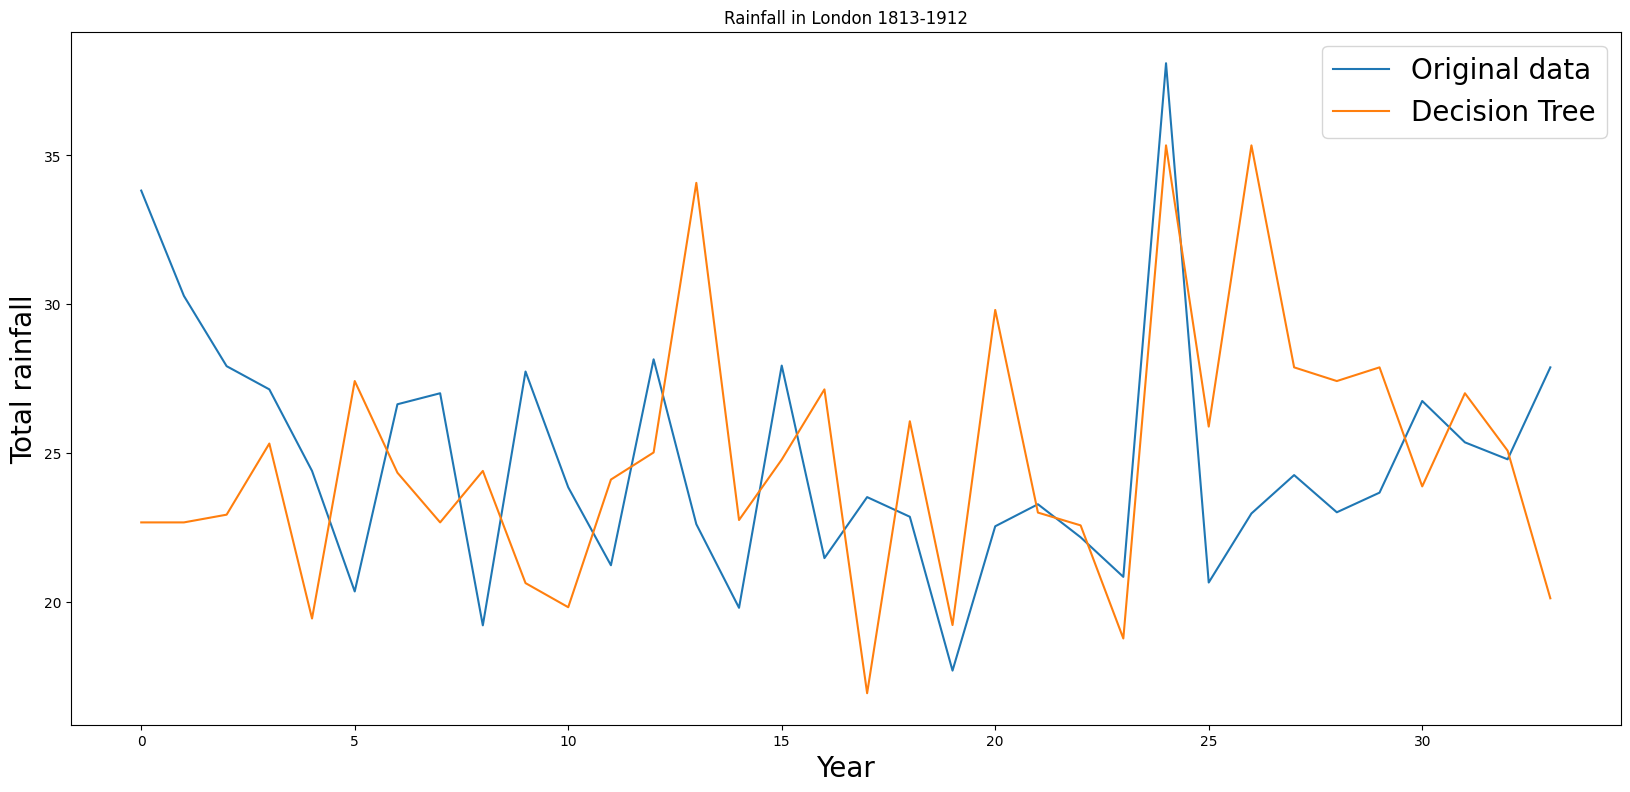

In [47]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions2, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Rainfall in London 1813-1912')
plt.ylabel('Total rainfall', fontsize="20")
plt.xlabel('Year', fontsize="20")
plt.show()

###  Сравнение предсказаний рандомного леса и дерева решений

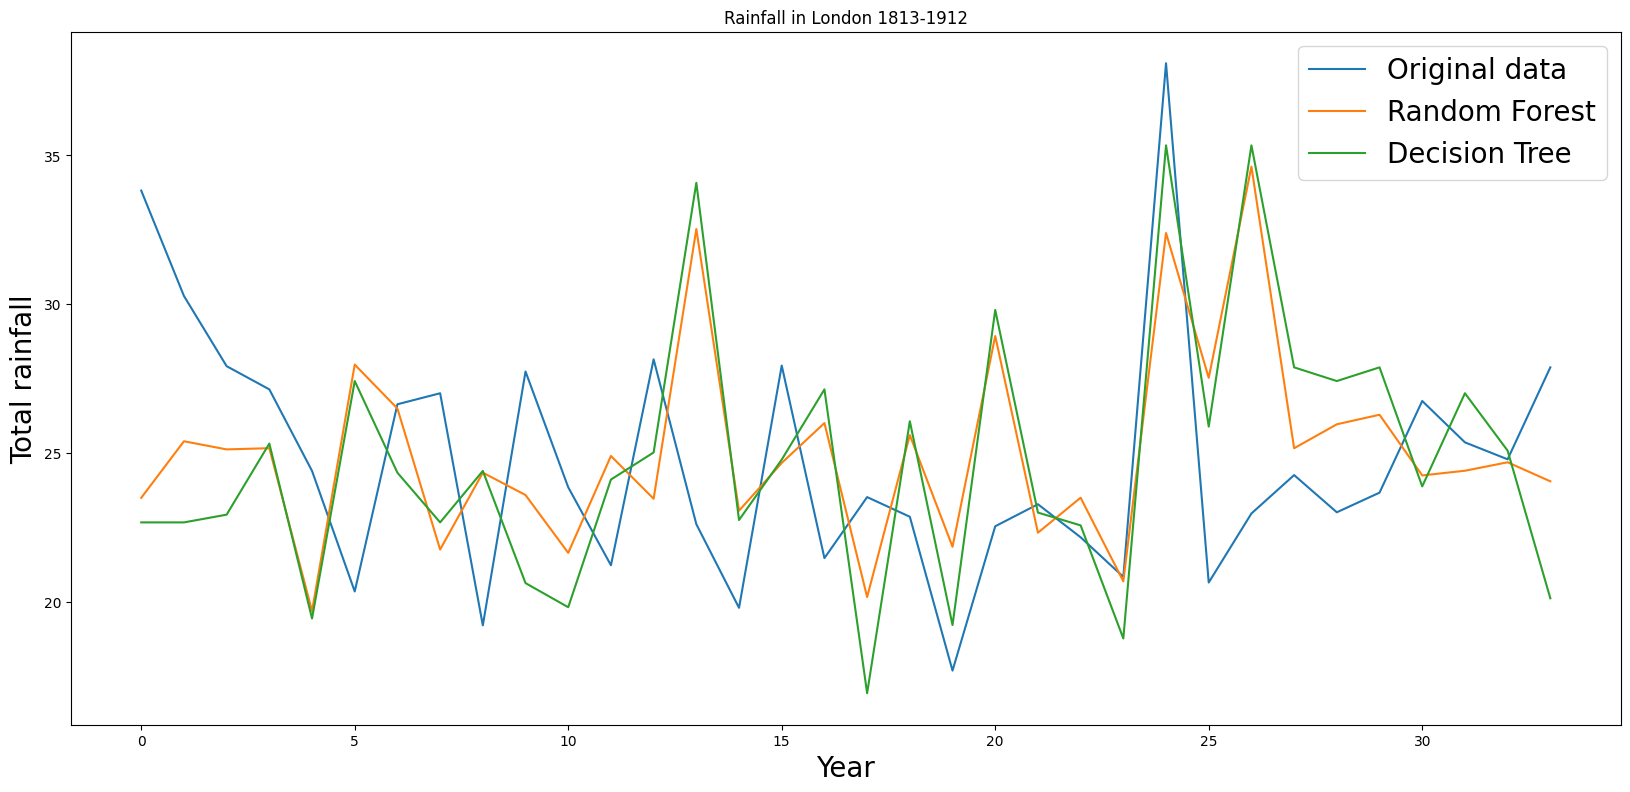

In [48]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.plot(predictions2, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Rainfall in London 1813-1912')
plt.ylabel('Total rainfall', fontsize="20")
plt.xlabel('Year', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

Алгоритм Isolation Forest основан на принципе случайного разбиения пространства признаков, таким образом, что изолированные точки отсекаются от нормальных кластеризованных данных. Данный метод позволяет выделить те объекты, параметры которых отклоняются от параметров большинства других объектов.

In [ ]:
!pip install plotly

In [1]:
from sklearn.ensemble import IsolationForest

In [4]:
#Читаем файл
df = pd.read_csv("../data/Total annual rainfall in inches London England 1813  1912.csv")
df = df['x']
df.head()

0    23.56
1    26.07
2    21.86
3    31.24
4    23.65
Name: x, dtype: float64

In [8]:
model = IsolationForest(contamination=0.004)
df = df.to_frame()
model.fit(df)

IsolationForest(contamination=0.004)

In [9]:
# Фильтруем выбросы
df['outliers'] = pd.Series(model.predict(df[['x']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [11]:
# Печатаем выбросы
df.query('outliers=="yes"')

,x,outliers
90,38.1,yes


In [18]:
import plotly.express as px

fig = px.scatter(df.reset_index(), x='index', y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()